### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [2]:
#Reading the data
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
df = x[:,2]

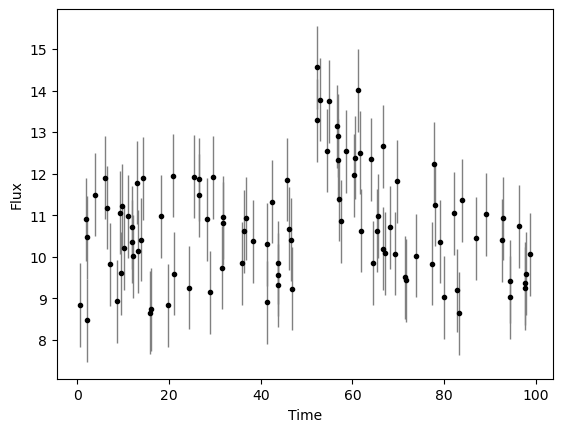

In [3]:
#Plot of the data with uncertanties
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [4]:
#Defining the exponential burst model
def burst(time, theta):
    A, b, t0, alpha = theta
    return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))

#Defining the gaussian model
def gaussian(time, theta):
    A, b, t0, sigma = theta
    return b + A*np.exp(-((time-t0)**2)/(2*(sigma**2)))

## Fit by eye

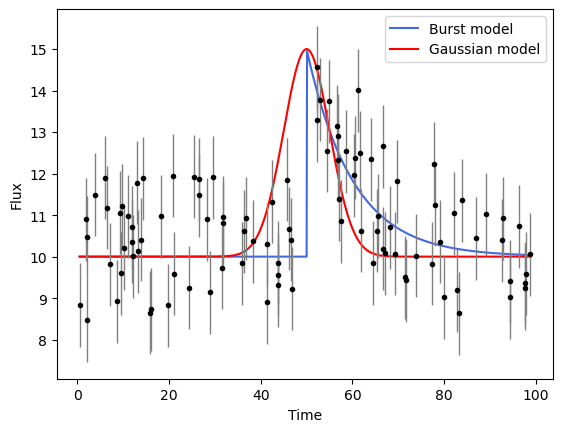

In [5]:
#Fitting the data with the two models by guessing the values of the parameters by eye
A_eye = 5  #Burst/gaussian amplitude
b_eye = 10  #Background amplitude
t0_eye = 50  #Burst/gaussian epoch
alpha_eye = 0.1  #How rapidly the burst dies off
sigma_eye = 5  #Sigma of the gaussian
theta_eye_burst = [A_eye, b_eye, t0_eye, alpha_eye]
theta_eye_gaussian = [A_eye, b_eye, t0_eye, sigma_eye]

time_grid = np.linspace(time.min(), time.max(), 1000)

plt.plot(time_grid, burst(time_grid, theta_eye_burst), color = 'royalblue', label = 'Burst model')
plt.plot(time_grid, gaussian(time_grid, theta_eye_gaussian), color = 'red', label = 'Gaussian model')
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [6]:
A_min, A_max = 0, 50
b_min, b_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigma_min, sigma_max = np.exp(-2), np.exp(2)
labels_burst = ['A', 'b', r'$t_0$', r'$\alpha$']
labels_gaussian = ['A', 'b', r'$t_0$', r'$\sigma_{w}$']

In [7]:
#Defining the log-likelihood of both models
def LogLikelihood(theta, df, flux, model):
    if model == 'burst':
        y_fit = burst(time, theta)
    if model == 'gaussian':
        y_fit = gaussian(time, theta)
    return -0.5 * np.sum((flux-y_fit)**2 / df**2) 

#Defining the log-prior of both models
def prior(u, model):
    #Dynesty draws parameters from the unitary hypercube space,[0,1]^n, where n is the number of parameter. So we havo to transform u to obtain
    #our paramters of interest
    param = np.copy(u)
    #The next function computes the quantile function for a uniform distribution
    param[0] = scipy.stats.uniform.ppf(u[0], loc = A_min, scale = A_max-A_min)
    param[1] = scipy.stats.uniform.ppf(u[1], loc = b_min, scale = b_max-b_min)
    param[2] = scipy.stats.uniform.ppf(u[2], loc = t0_min, scale = t0_max-t0_min)
    if model == 'burst':
        param[3] = scipy.stats.loguniform.ppf(u[3], alpha_min, alpha_max)
    if model == 'gaussian':
        param[3] = scipy.stats.loguniform.ppf(u[3], sigma_min, sigma_max)
    return param

## Nested sampling with burst model

In [8]:
ndim = 4
sampler_burst = dynesty.NestedSampler(LogLikelihood, prior, ndim, logl_args=[df, flux, 'burst'],
                                      ptform_args=['burst'], nlive = 500)  #Defining the sampler using 500 livepoints
sampler_burst.run_nested()
sresults_burst = sampler_burst.results  #Runinng the sampler

C:\Users\restu\AppData\Local\Temp\ipykernel_20052\2594260097.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
C:\Users\restu\AppData\Local\Temp\ipykernel_20052\2594260097.py:4: RuntimeWarning: overflow encountered in multiply
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
1790it [00:14, 46.26it/s, bound: 0 | nc: 26 | ncall: 17850 | eff(%): 10.028 | loglstar:   -inf < -183.226 <    inf | logz: -191.834 +/-  0.123 | dlogz: 121.185 >  0.509]    C:\Users\restu\AppData\Local\Temp\ipykernel_20052\2594260097.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
C:\Users\restu\AppData\Local\Temp\ipykernel_20052\2594260097.py:4: RuntimeWarning: overflow encountered in multiply
  return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))
1849it [00:15, 73.03it/s, bound: 1 | nc: 22 | ncall: 18578 | eff(%):  9.953 | loglstar:   -inf < -166.935 <    inf | logz: -175.814 +

#### Runplot

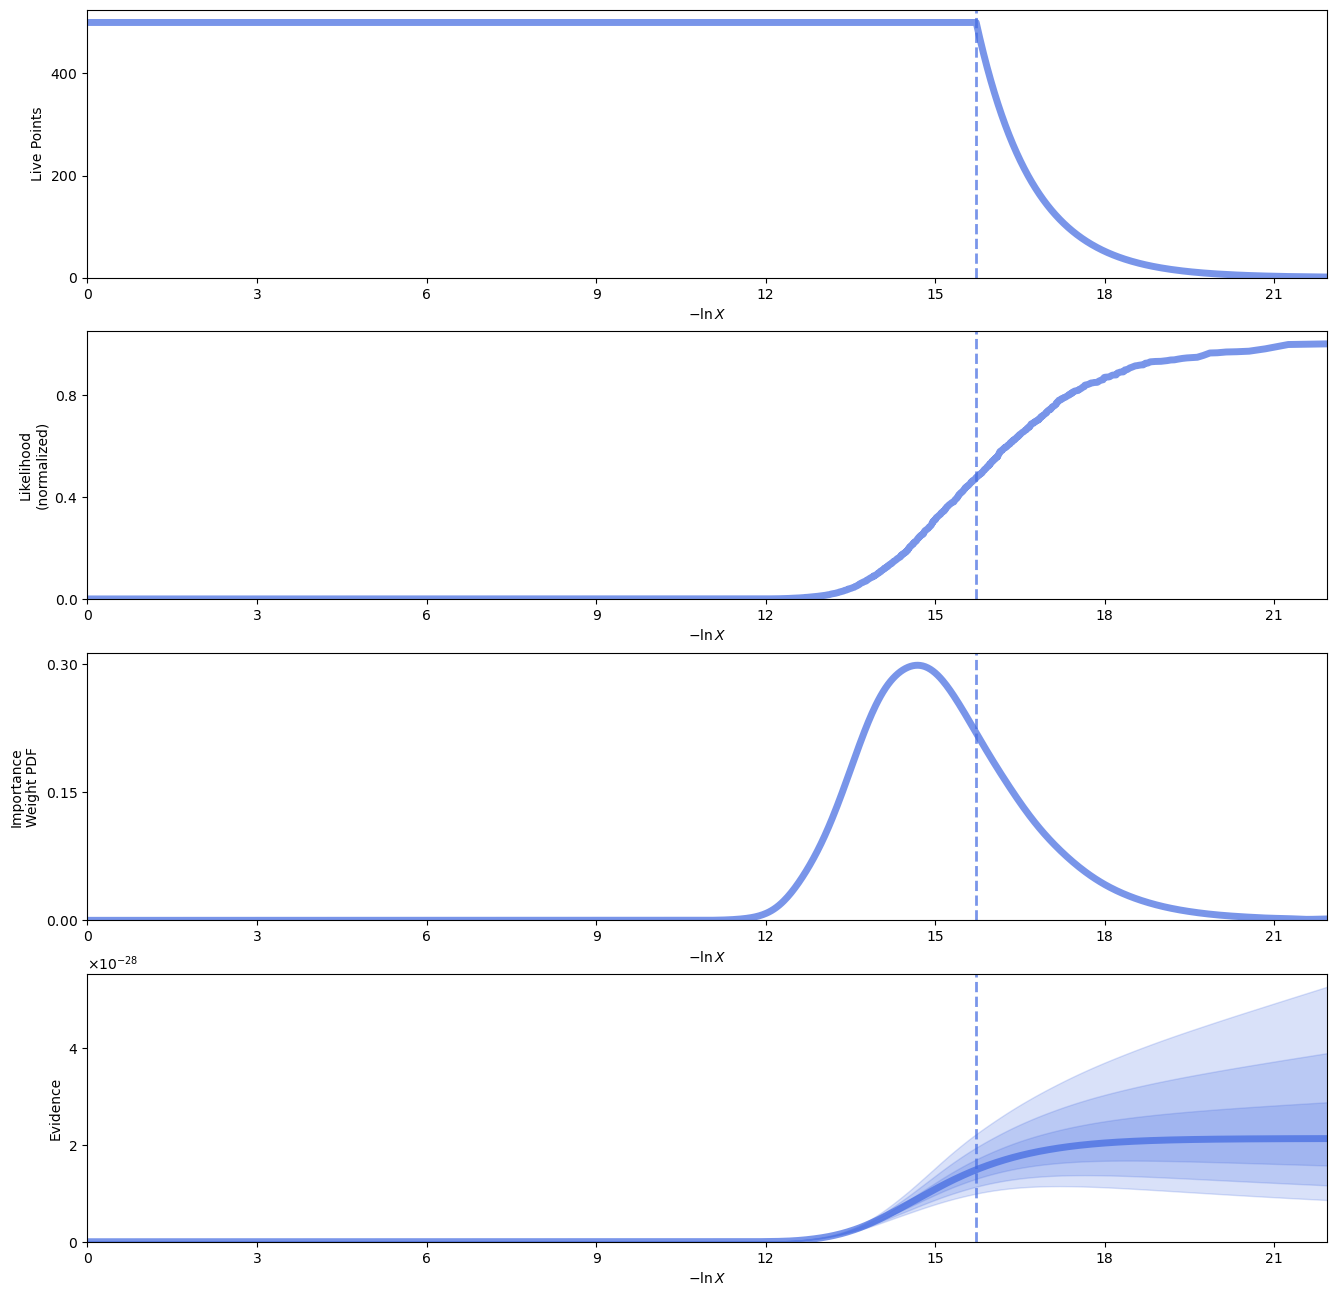

In [9]:
rfig_burst, raxes_burst = dyplot.runplot(sresults_burst, color = 'royalblue')

#### Traceplot

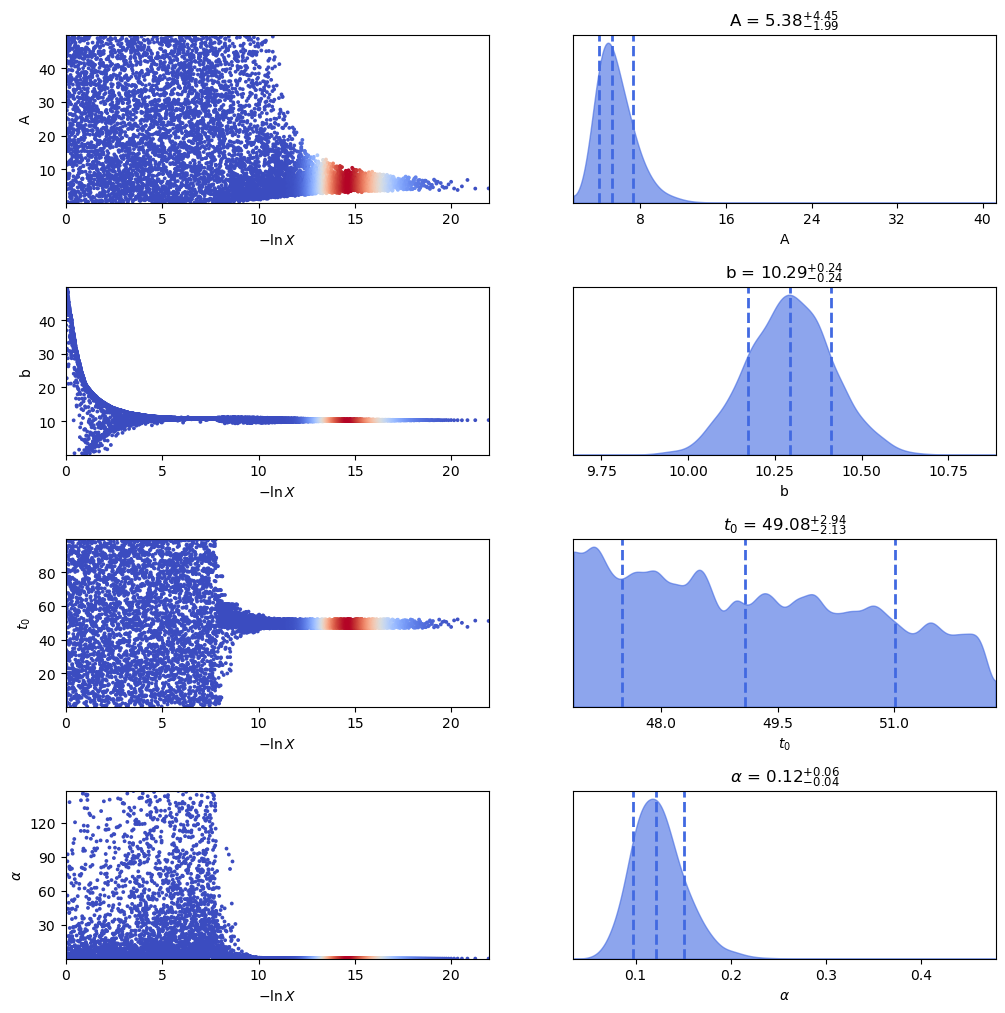

In [10]:
tfig_burst, taxes_burst = dyplot.traceplot(sresults_burst, labels = labels_burst, post_color='royalblue', trace_cmap='coolwarm', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

#### Cornerplots

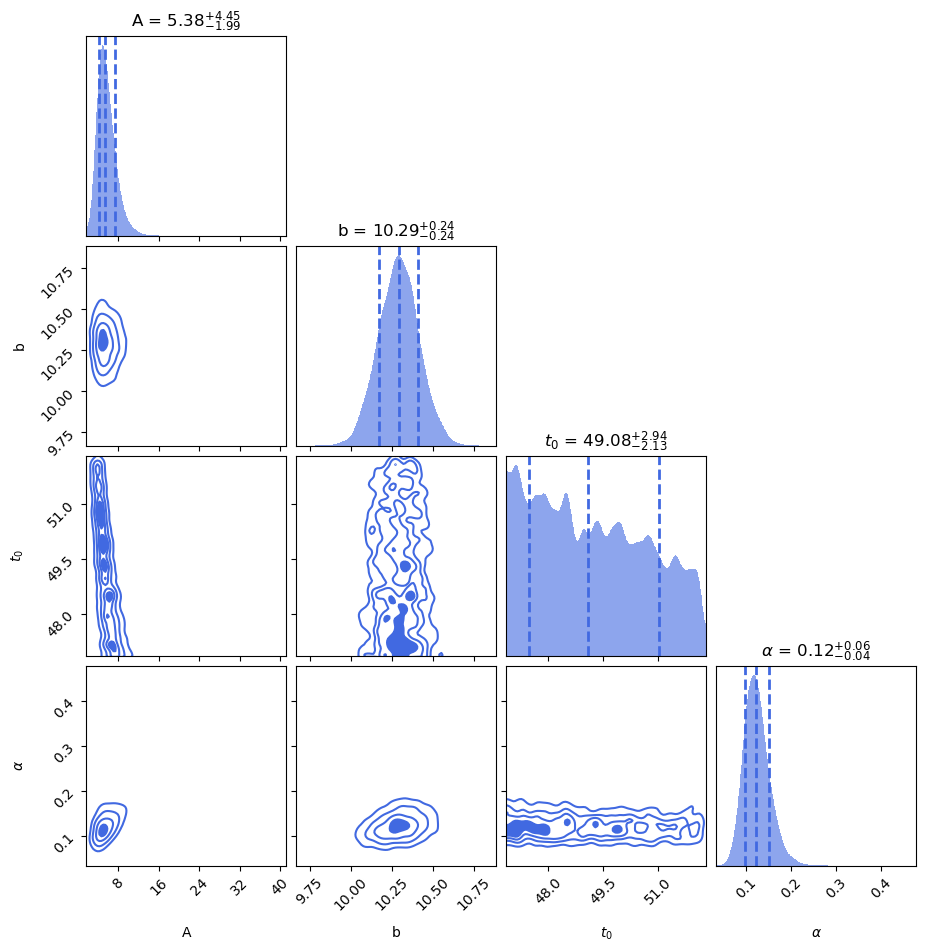

In [11]:
cfig_burst, caxes_burst = dyplot.cornerplot(sresults_burst, labels = labels_burst, quantiles=[0.16, 0.5, 0.84], show_titles=True, color = 'royalblue')

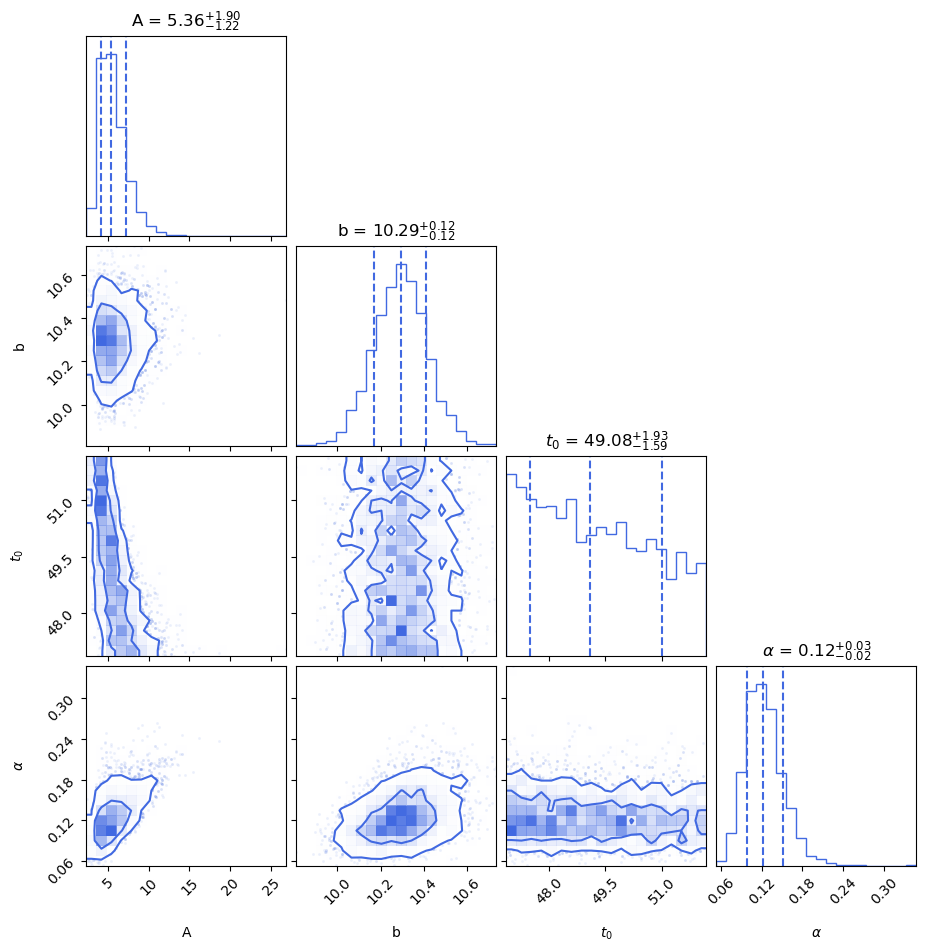

In [12]:
#The samples that dynesty gives are weighted so we have to reweight them
samples_burst = sresults_burst.samples 
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])
samples_burst_equal = dyfunc.resample_equal(samples_burst, weights_burst)
corner.corner(samples_burst_equal, labels=labels_burst, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], color = 'royalblue');

In [13]:
evidence_burst = sresults_burst.logz[-1] #Computing the log-evidence
print("Bayesian evidence", np.exp(evidence_burst))

mean_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, weights_burst)  #Computing weighted mean and covariance
print('\nMean and covariance of parameters are:\n' + str(mean_burst) + '\n\n' + str(cov_burst))

Bayesian evidence 2.133086131707395e-28

Mean and covariance of parameters are:
[ 5.70794086 10.29288731 49.21308886  0.12435135]

[[ 2.88675240e+00  7.84469672e-03 -1.74818612e+00  2.84407941e-02]
 [ 7.84469672e-03  1.48311501e-02 -2.90980445e-03  1.15143184e-03]
 [-1.74818612e+00 -2.90980445e-03  2.31812420e+00 -2.68381488e-03]
 [ 2.84407941e-02  1.15143184e-03 -2.68381488e-03  7.66350917e-04]]


## Nested sampling with gaussian model

In [14]:
ndim = 4
sampler_gaussian = dynesty.NestedSampler(LogLikelihood, prior, ndim, logl_args=[df, flux, 'gaussian'], ptform_args=['gaussian'], nlive = 500)
sampler_gaussian.run_nested()
sresults_gaussian = sampler_gaussian.results

4085it [01:24, 10.67it/s, bound: 67 | nc: 168 | ncall: 68970 | eff(%):  5.923 | loglstar:   -inf < -86.410 <    inf | logz: -94.515 +/-  0.117 | dlogz: 32.100 >  0.509]     C:\Users\restu\anaconda3\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4615it [02:00, 14.34it/s, bound: 99 | nc: 7 | ncall: 92997 | eff(%):  4.963 | loglstar:   -inf < -78.748 <    inf | logz: -89.833 +/-  0.141 | dlogz: 26.369 >  0.509]  C:\Users\restu\anaconda3\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using 

#### Runplot

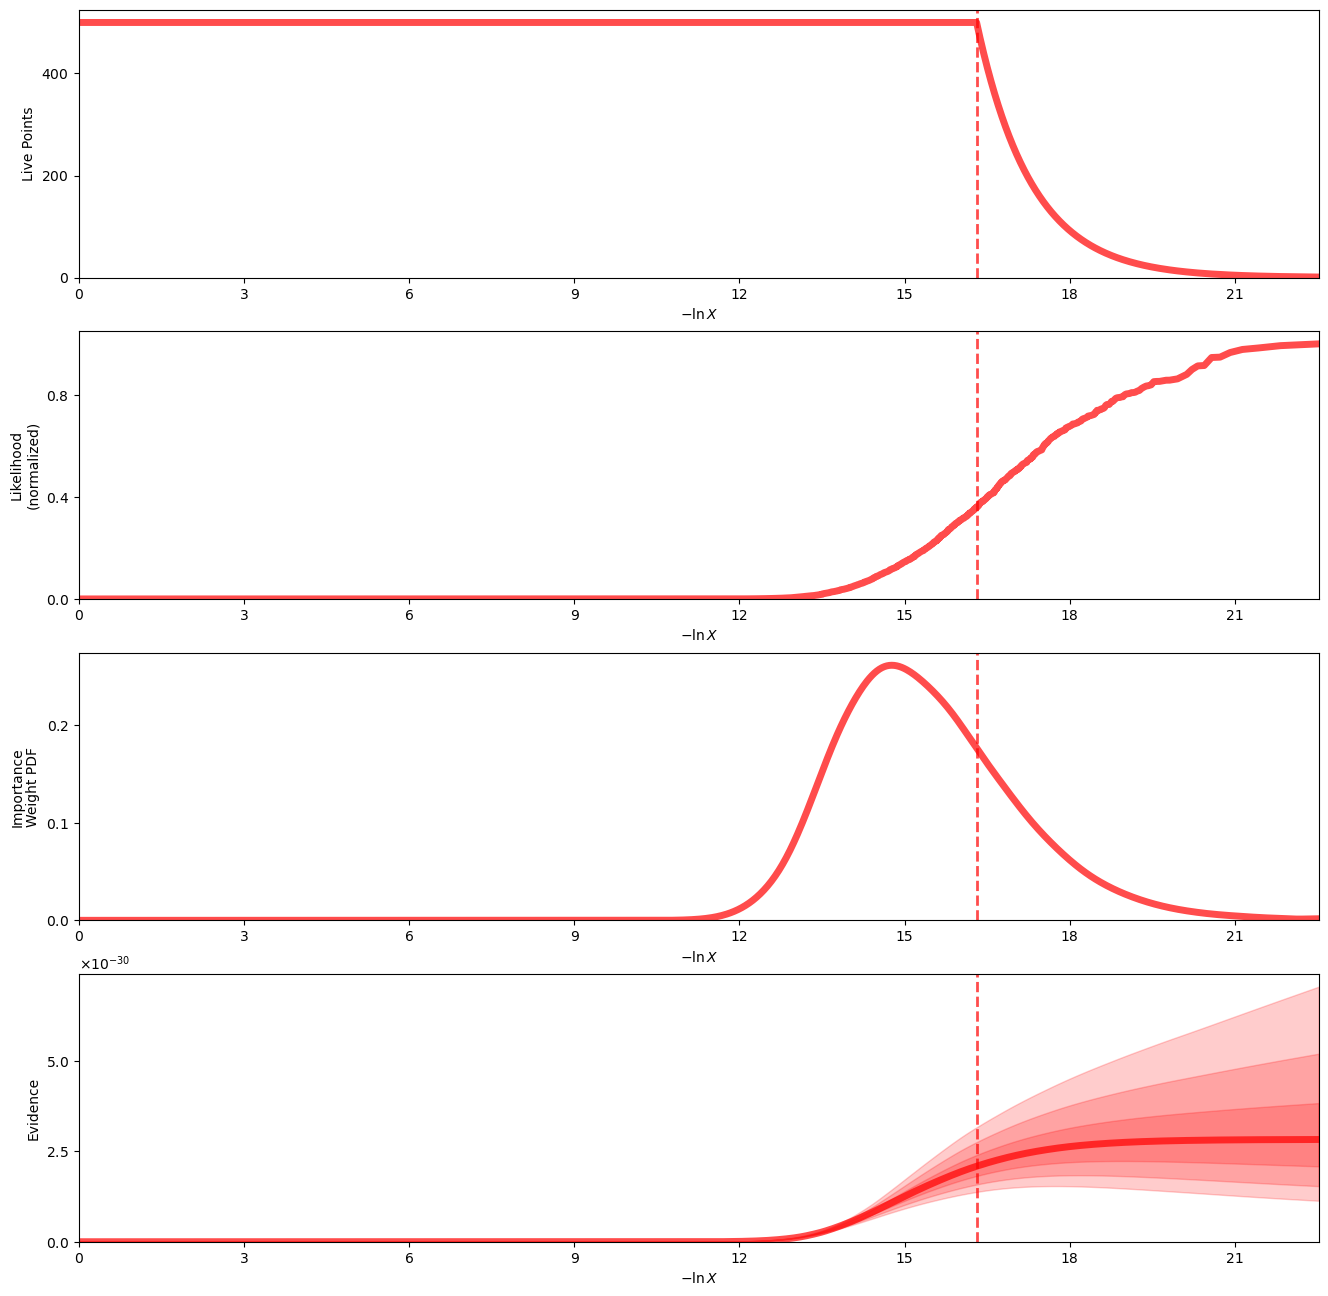

In [15]:
rfig_gaussian, raxes_gaussian = dyplot.runplot(sresults_gaussian, color = 'red')

#### Traceplot

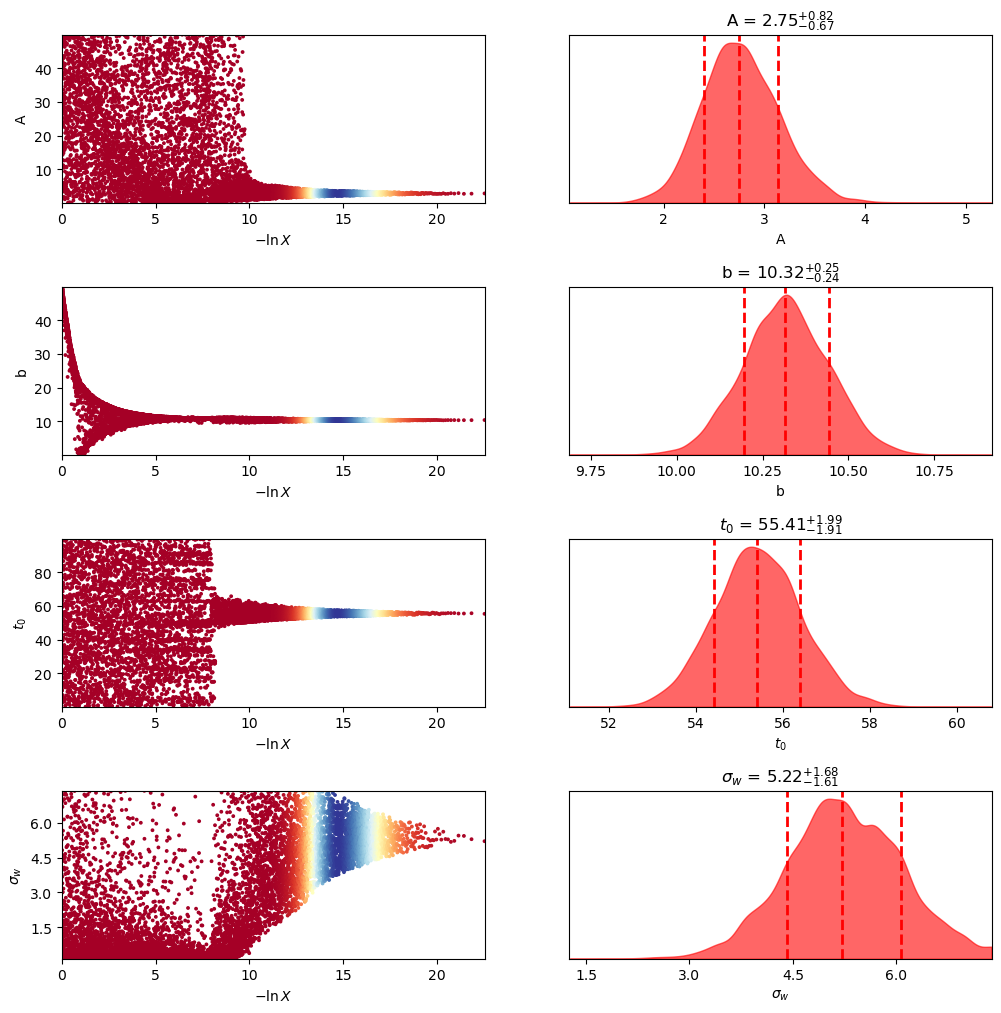

In [16]:
tfig_gaussian, taxes_gaussian = dyplot.traceplot(sresults_gaussian, labels = labels_gaussian, post_color='red', trace_cmap='RdYlBu', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

#### Cornerplots

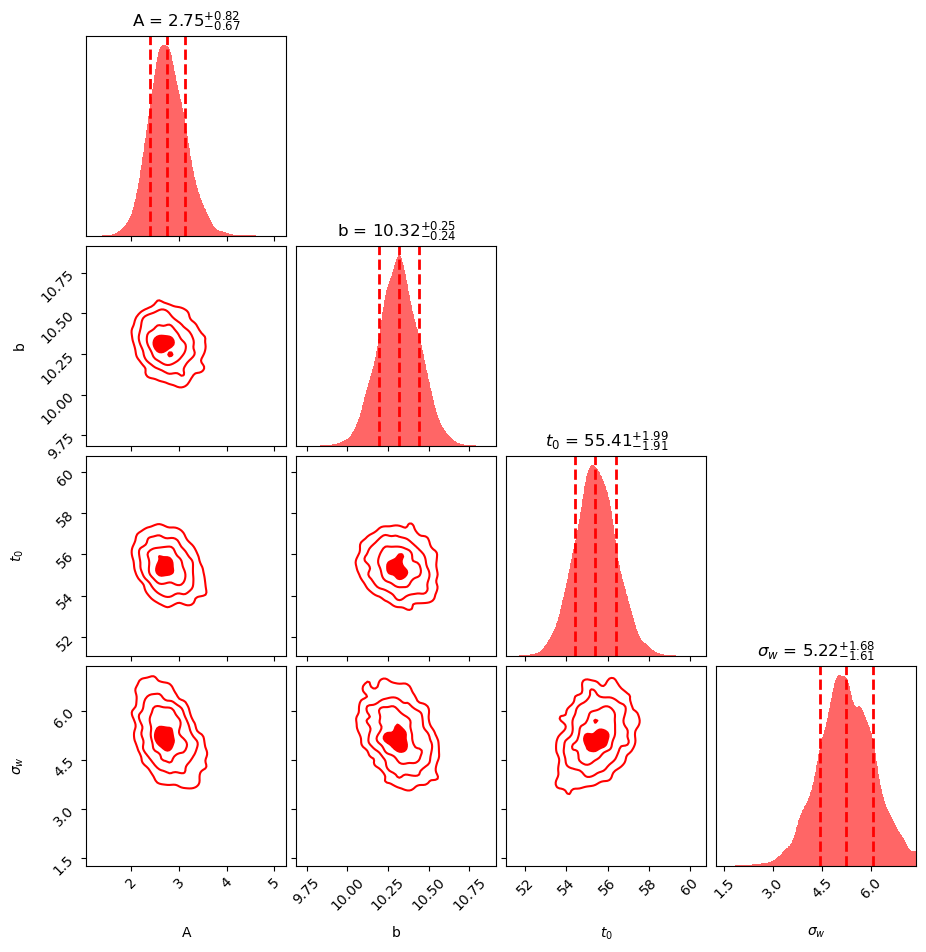

In [17]:
cfig_gaussian, caxes_gaussian = dyplot.cornerplot(sresults_gaussian, labels = labels_gaussian, quantiles=[0.16, 0.5, 0.84], show_titles=True, color = 'red')

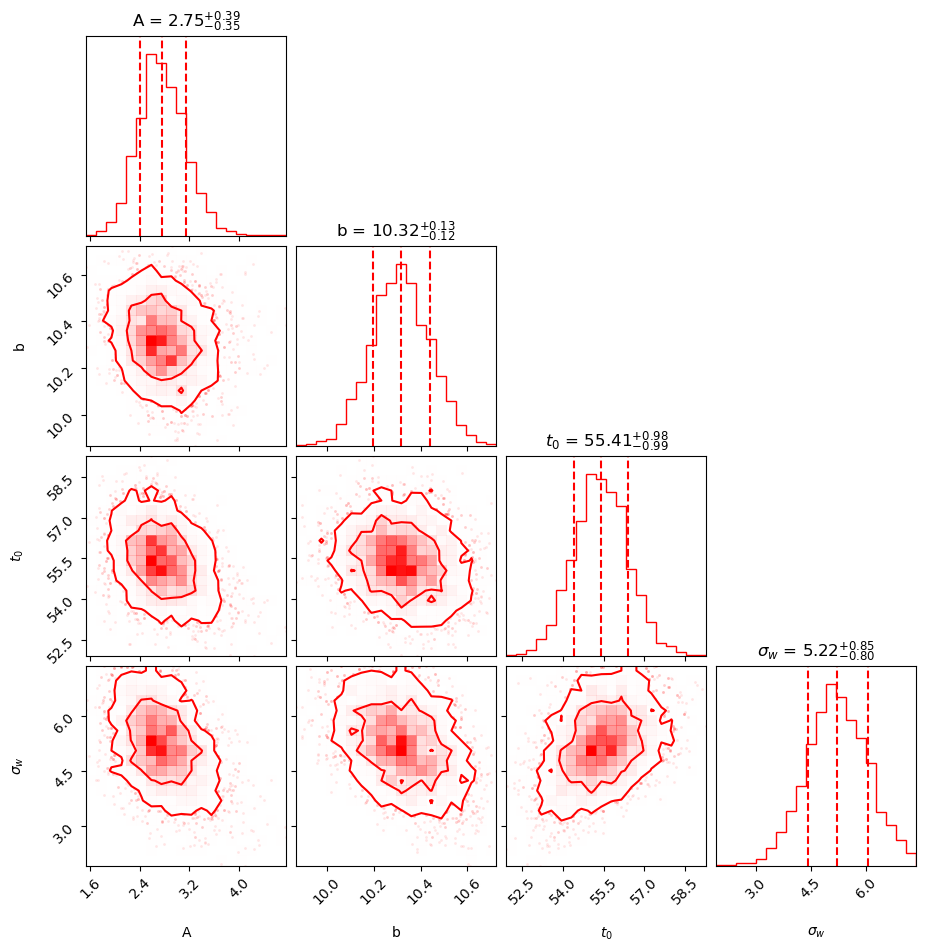

In [18]:
samples_gaussian = sresults_gaussian.samples
weights_gaussian = np.exp(sresults_gaussian.logwt - sresults_gaussian.logz[-1])
samples_gaussian_equal = dyfunc.resample_equal(samples_gaussian, weights_gaussian)
corner.corner(samples_gaussian_equal, labels=labels_gaussian, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], color = 'red');

In [19]:
evidence_gaussian = sresults_gaussian.logz[-1]
print("Bayesian evidence", np.exp(evidence_gaussian))

mean_gaussian, cov_gaussian = dyfunc.mean_and_cov(samples_gaussian, weights_gaussian)
print('\nMean and covariance of parameters are:\n' + str(mean_gaussian) + '\n\n' + str(cov_gaussian))

Bayesian evidence 2.827976888011812e-30

Mean and covariance of parameters are:
[ 2.76684459 10.31720724 55.42043565  5.23292054]

[[ 0.14435728 -0.00907447 -0.12318413 -0.12312195]
 [-0.00907447  0.01539788 -0.0223878  -0.03757411]
 [-0.12318413 -0.0223878   0.99061181  0.29155398]
 [-0.12312195 -0.03757411  0.29155398  0.69274529]]


## Model comparison

In [20]:
print('Burst model summary:')
sresults_burst.summary()
print('\nGaussian model summary:')
sresults_gaussian.summary()

Burst model summary:
Summary
nlive: 500
niter: 7869
ncall: 110693
eff(%):  7.561
logz: -63.715 +/-  0.302

Gaussian model summary:
Summary
nlive: 500
niter: 8161
ncall: 110380
eff(%):  7.847
logz: -68.038 +/-  0.305


## Bayes factor

In [21]:
print('The logarithmic Bayes factor is: ', np.log(np.exp(sresults_burst.logz[-1])/np.exp(sresults_gaussian.logz[-1])))

The logarithmic Bayes factor is:  4.32317842976434


According to the Jeffreys Scale there is a "very strong evidence" that the burst model is better then the gaussian model.